In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

In [11]:
# settings to display all columns
pd.set_option("display.max_columns", None)

In [12]:
df = pd.read_csv('../../data/data.csv')
y = pd.read_csv('../../data/status.csv')

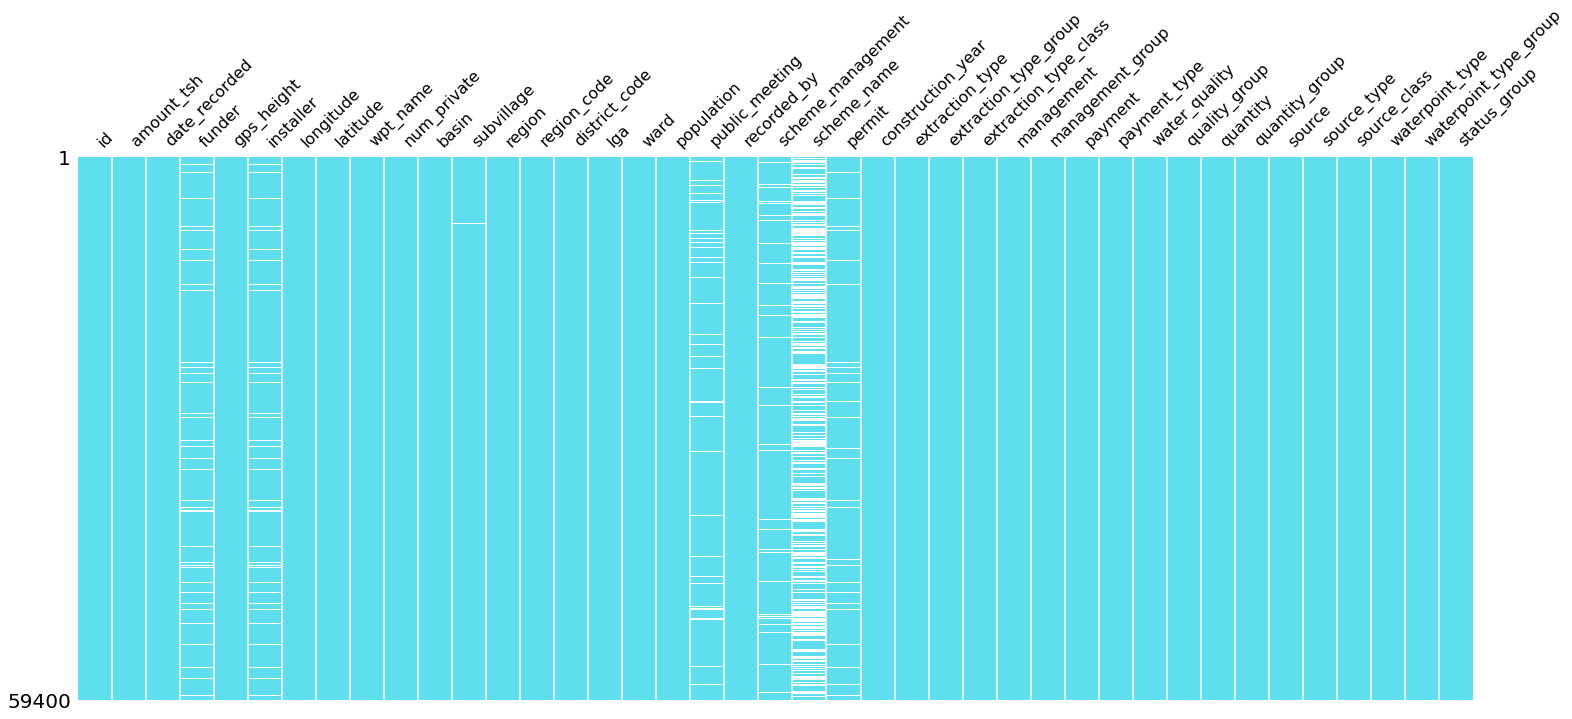

In [24]:
fig = msno.matrix(df, color=(95/255, 223/255, 237/255), sparkline=False)
fig_copy = fig.get_figure()
fig_copy.savefig('missingno.png')

In [13]:
df = df.merge(y,left_on ='id', right_on='id')

<AxesSubplot:>

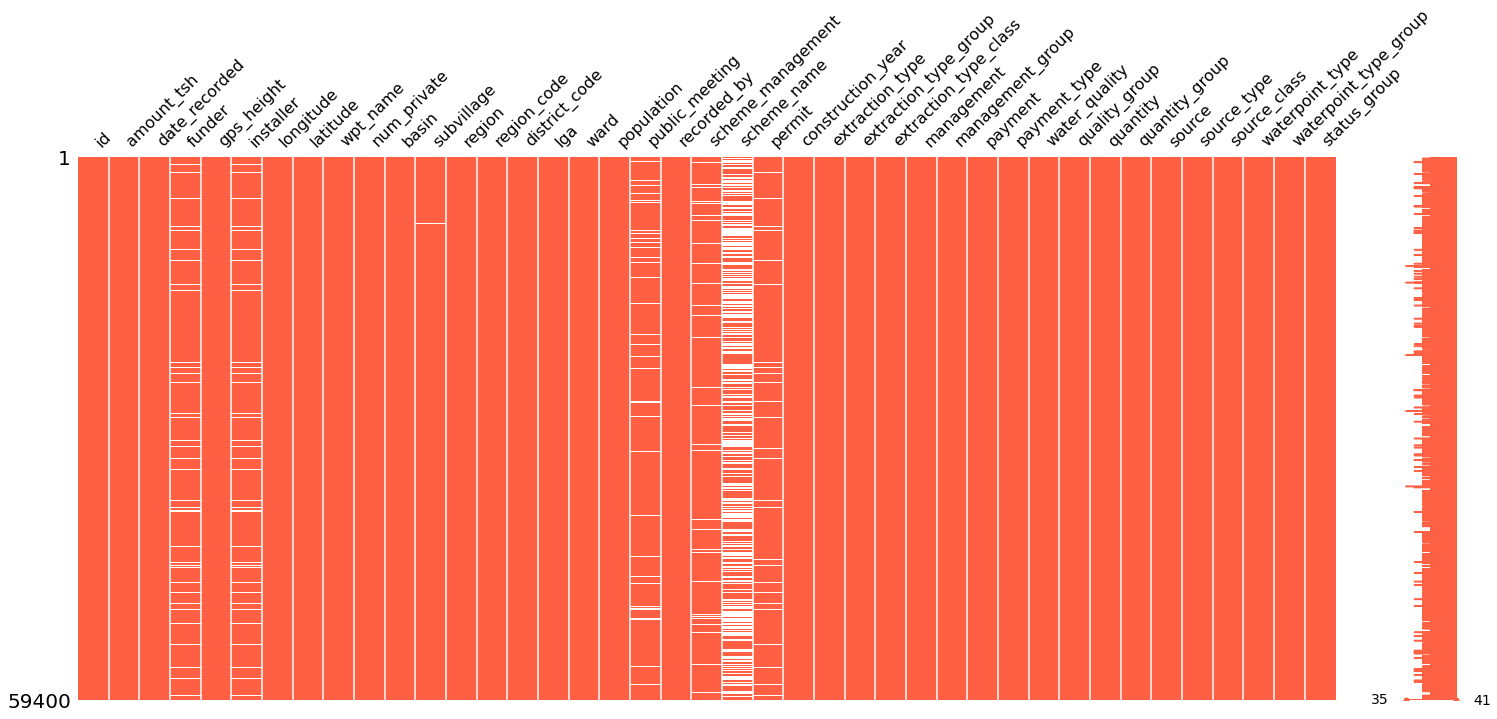

In [6]:
ttl_missing = df.isna().sum().sum()

In [14]:
df.shape

(59400, 41)

In [20]:
df['date_recorded'].value_counts().sort_index(ascending=False)

2013-12-03    240
2013-12-02     33
2013-12-01      1
2013-11-03    194
2013-11-02     24
             ... 
2004-04-01      1
2004-03-06      1
2004-03-01      4
2004-01-07      1
2002-10-14      1
Name: date_recorded, Length: 356, dtype: int64

In [8]:
ttl_cells = df.shape[0]*df.shape[1]

In [9]:
percent_missing = (ttl_missing/ttl_cells)*100

In [10]:
percent_missing


1.8926665024226

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [12]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### Numeric Column Review

ID - needed to align data? if remaining will "noise" up models

amount_tsh - 180 rows above 10k,

gps_height - numbers make sense, highest pt in Tanzania is 5,895 meters (19,340 feet) so works for either metric drop negative per wiki Tanzania's lowest point is at sea level

**There are ~20,000 rows where amt_tsh, gps_height, population, construction year all equal 0**

long/lat = ~1800 (0,0) values, I say drop, otherwise ranges make sense


num_private = no description, 98% of the column 0s, drop



region_code = totally normal, probs redundant with region, kind of already encoded so recommend droping region? Maybe? 

district_code = numbers are all over the place, should drop because I think these may be region specific, so unless we concatenate w/region code no inherent meaning

population - 21000 where pop is 0 - should we drop these? can't imagine it's true.... fill w/mean? 

construction_year = see above about the 20,000 rows - that's a LOT of data to replace... SMOTE???? can't use the mean...

In [26]:
1800/54000

0.03333333333333333

TO DO (Numeric):


- For amt_tsh - log transform to deal with outliers
- gps_height - ignore negatives, no change
- lat/long - make 0s NAN
- num_private - DROP
- region_code - keep that or region
- district_code - DROP but option to engineer feature by combining w/region or region_code
- population - , no other change to column because we can't tell missing from isolated area? can fill in with avg population of region or district
- construction_year - figure out how we want to fill in the blanks (mean? Unknown?)

In [13]:
amt_tsh_vc = df['amount_tsh'].value_counts().sort_index(ascending=False)

In [14]:
df[df['amount_tsh']>0].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000
mean,36954.649344,1062.351942,967.609988,35.946115,-6.729044,0.864985,14.822983,5.516806,268.460278,1952.852317
std,21384.290986,5409.344940,628.573308,2.620310,2.566116,21.015198,19.645351,9.804546,551.545827,299.280735
min,3.000000,0.200000,-90.000000,29.607122,-11.649440,0.000000,2.000000,1.000000,0.000000,0.000000
25%,18430.000000,50.000000,353.000000,34.707370,-8.978955,0.000000,5.000000,2.000000,30.000000,1990.000000
50%,36852.000000,250.000000,1031.000000,36.458139,-6.764674,0.000000,11.000000,3.000000,130.000000,2002.000000
75%,55429.000000,1000.000000,1481.000000,37.811420,-4.483061,0.000000,15.000000,4.000000,300.000000,2008.000000
max,74247.000000,350000.000000,2568.000000,40.345193,-1.094797,1776.000000,99.000000,67.000000,11463.000000,2013.000000


In [15]:
df['gps_height'].value_counts().sort_index(ascending=False)

 2770    1
 2628    1
 2627    1
 2626    2
 2623    1
        ..
-55      1
-57      1
-59      1
-63      2
-90      1
Name: gps_height, Length: 2428, dtype: int64

In [16]:
df_below_sea_level = df[df['gps_height'] < 0]
df_below_sea_level

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
34,41583,0.0,2011-02-23,NaN,-41,NaN,39.812912,-7.889986,Msikitini Wa Ijumaa,0,Rufiji,Kilombero B,Pwani,60,63,Mafia,Baleni,100,True,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
152,60983,0.0,2013-03-16,0,-15,0,39.527114,-6.988748,Msikitini,0,Wami / Ruvu,Madrasa,Dar es Salaam,7,3,Temeke,Kimbiji,50,True,GeoData Consultants Ltd,VWC,NaN,False,1970,mono,mono,motorpump,vwc,user-group,never pay,never pay,salty,salty,dry,dry,machine dbh,borehole,groundwater,other,other,non functional
181,68908,0.0,2011-03-05,NaN,-21,NaN,39.670943,-7.906606,Royal,0,Rufiji,Kigamboni,Pwani,60,60,Mafia,Kilindoni,32,True,GeoData Consultants Ltd,VWC,NaN,False,0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
184,2136,0.0,2011-02-22,NaN,-16,NaN,39.854320,-7.783063,Mvivini,0,Rufiji,Jimbo Mjini,Pwani,60,63,Mafia,Kirongwe,230,True,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
249,35193,0.0,2011-03-16,Amref,-19,AMREF,39.244178,-7.368293,Kwa,0,Rufiji,Kimogola,Pwani,6,4,Mkuranga,Magawa,500,True,GeoData Consultants Ltd,VWC,NaN,False,2007,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59200,20017,0.0,2013-02-08,Amref,-3,Amref,40.160806,-10.578354,Kwa Rashid Haya,0,Ruvuma / Southern Coast,Misri,Mtwara,99,1,Mtwara Rural,Chawi,250,True,GeoData Consultants Ltd,VWC,Ngonja water supply,True,2012,mono,mono,motorpump,vwc,user-group,unknown,unknown,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
59243,3396,50.0,2013-03-16,0,-20,0,39.524021,-6.984802,Kwa Mariwala,0,Wami / Ruvu,Miembe Dekwa,Dar es Salaam,7,3,Temeke,Kimbiji,210,True,GeoData Consultants Ltd,VWC,NaN,False,2010,nira/tanira,nira/tanira,handpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59251,65997,0.0,2013-01-24,Serikali,-37,Serikali,39.736299,-9.884813,Kwa Asha Mgugi,0,Ruvuma / Southern Coast,Mbanja B,Lindi,80,62,Lindi Rural,Mbanja,300,True,GeoData Consultants Ltd,NaN,NaN,True,1981,gravity,gravity,gravity,vwc,user-group,unknown,unknown,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe multiple,communal standpipe,functional
59351,55322,50.0,2013-03-18,0,-19,0,39.534599,-7.088183,Kwa China,0,Wami / Ruvu,Bondeni,Dar es Salaam,7,3,Temeke,Pemba Mnazi,50,True,GeoData Consultants Ltd,VWC,NaN,False,2000,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


In [17]:
df_below_sea_level['scheme_management'].value_counts(normalize=True)

VWC                 0.551150
Company             0.150674
Private operator    0.126883
SWC                 0.056305
WUG                 0.038858
Parastatal          0.032514
Water authority     0.023791
Other               0.009516
Trust               0.007137
Water Board         0.001586
None                0.000793
WUA                 0.000793
Name: scheme_management, dtype: float64

In [18]:
df['scheme_management'].value_counts(normalize=True)

VWC                 0.662662
WUG                 0.093763
Water authority     0.056787
WUA                 0.051924
Water Board         0.049493
Parastatal          0.030258
Private operator    0.019145
Company             0.019109
Other               0.013796
SWC                 0.001747
Trust               0.001297
None                0.000018
Name: scheme_management, dtype: float64

In [19]:
df_below_sea_level.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000
mean,37297.606952,313.013369,-19.993316,39.352801,-7.727535,0.506684,34.703877,15.531417,258.137032,1686.096257
std,21119.500129,4017.641868,12.154136,0.458811,1.542230,7.155227,35.259116,21.812220,428.417873,726.379806
min,150.000000,0.000000,-90.000000,38.614960,-10.946096,0.000000,4.000000,1.000000,1.000000,0.000000
25%,19232.750000,0.000000,-28.000000,38.972421,-8.584131,0.000000,6.000000,1.000000,40.000000,1976.000000
50%,36699.000000,0.000000,-18.000000,39.281546,-7.415977,0.000000,7.000000,5.000000,102.500000,2000.000000
75%,55492.750000,50.000000,-11.000000,39.662349,-6.524902,0.000000,60.000000,13.000000,320.000000,2008.000000
max,74211.000000,138000.000000,-1.000000,40.345193,-5.278598,150.000000,99.000000,67.000000,4520.000000,2013.000000


In [20]:
df_below_sea_level.isna().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                    132
gps_height                  0
installer                 132
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                  0
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting             41
recorded_by                 0
scheme_management         235
scheme_name              1052
permit                      0
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity  

In [21]:
df_zeros = df[(df['gps_height'] == 0) & (df['amount_tsh']==0)&(df['population']==0)&(df['construction_year']==0)]

In [22]:
df_zeros.shape

(19668, 41)

In [23]:
df_zeros

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,Internal,Ishinabulandi,Shinyanga,17,3,Shinyanga Rural,Samuye,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,Lake Tanganyika,Nyawishi Center,Shinyanga,17,3,Kahama,Chambo,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,Lake Tanganyika,Imalauduki,Tabora,14,6,Tabora Urban,Itetemia,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,Lake Victoria,Mkonomre,Kagera,18,1,Karagwe,Kaisho,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59384,72148,0.0,2011-07-10,Concern,0,CONCERN,30.667805,-2.483710,Chamkube,0,Lake Victoria,Songambele,Kagera,18,30,Ngara,Nyamiyaga,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
59392,40607,0.0,2011-04-15,Government Of Tanzania,0,Government,33.009440,-8.520888,Benard Charles,0,Lake Rukwa,Mbuyuni A,Mbeya,12,1,Chunya,Mbuyuni,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
59393,48348,0.0,2012-10-27,Private,0,Private,33.866852,-4.287410,Kwa Peter,0,Internal,Masanga,Tabora,14,2,Igunga,Igunga,0,False,GeoData Consultants Ltd,Water authority,NaN,False,0,gravity,gravity,gravity,private operator,commercial,pay per bucket,per bucket,soft,good,insufficient,insufficient,dam,dam,surface,other,other,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional


In [25]:
df_zeros['water_quality'].value_counts(normalize=True)

soft                  0.840299
salty                 0.071588
milky                 0.033710
unknown               0.030659
coloured              0.013067
salty abandoned       0.008593
fluoride              0.001678
fluoride abandoned    0.000407
Name: water_quality, dtype: float64

In [50]:
df_zeros['recorded_by'].value_counts()

GeoData Consultants Ltd    19668
Name: recorded_by, dtype: int64

In [53]:
df['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [54]:
df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

In [55]:
df['num_private'].value_counts(normalize=True)

0      0.987256
6      0.001364
1      0.001229
5      0.000774
8      0.000774
         ...   
180    0.000017
213    0.000017
23     0.000017
55     0.000017
94     0.000017
Name: num_private, Length: 65, dtype: float64

In [57]:
df_const_yr_zero = df[df['construction_year']==0]

In [58]:
df_const_yr_zero.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,20709.00000,20709.000000,20709.000000,20709.000000,2.070900e+04,20709.000000,20709.000000,20709.000000,20709.000000,20709.0
mean,37175.14781,39.631291,44.147231,30.516720,-4.717058e+00,0.037761,14.531943,4.994447,11.967550,0.0
std,21513.56027,1492.658704,257.210774,9.592703,3.024457e+00,2.020138,7.884525,7.187056,155.964828,0.0
min,0.00000,0.000000,-90.000000,0.000000,-1.147612e+01,0.000000,1.000000,0.000000,0.000000,0.0
25%,18573.00000,0.000000,0.000000,31.827634,-8.042476e+00,0.000000,12.000000,2.000000,0.000000,0.0
50%,37031.00000,0.000000,0.000000,33.153589,-3.856061e+00,0.000000,17.000000,3.000000,0.000000,0.0
75%,55936.00000,0.000000,0.000000,33.871355,-2.631934e+00,0.000000,18.000000,6.000000,0.000000,0.0
max,74242.00000,200000.000000,2215.000000,40.197541,-2.000000e-08,150.000000,99.000000,80.000000,6922.000000,0.0


In [59]:
df['region_code'].value_counts(normalize=True)

11    0.089226
17    0.084360
12    0.078098
3     0.073721
5     0.068013
18    0.055960
19    0.051296
2     0.050909
16    0.047407
10    0.044444
4     0.042306
1     0.037054
13    0.035236
14    0.033316
20    0.033148
15    0.030438
6     0.027088
21    0.026650
80    0.020842
60    0.017256
90    0.015438
7     0.013552
99    0.007121
9     0.006566
24    0.005488
8     0.005051
40    0.000017
Name: region_code, dtype: float64

In [60]:
df['district_code'].value_counts(normalize=True)

1     0.205438
2     0.188098
3     0.168316
4     0.151498
5     0.073333
6     0.068586
7     0.056279
8     0.017559
30    0.016751
33    0.014714
53    0.012542
43    0.008502
13    0.006582
23    0.004933
63    0.003283
62    0.001835
60    0.001061
0     0.000387
80    0.000202
67    0.000101
Name: district_code, dtype: float64

In [61]:
df['district_code'].isna().sum()

0

### Categorical Cols

- id = drop or index
- status_group - make binary
- scheme name - DROP
x- water point name - DROP
x- date_recorded = DROP
- funder - use that categorical value thing 
- installer - use that categorical value thing 
- wpt_name = DROP
- basin - perfect
x- subvillage - rtoo many uniques - DROP
- region - keep but DROP REGION CODE
- lga - keep it for now, first on chopping block  
x- ward - DROP 
x- public_meeting - DROP
x- recorded_by - DROP
- scheme_management - keep
x- scheme_name - DROP 
- permit - encode but on chopping block
x- extraction_type = DROP
x- extraction_type_group = DROP
- extraction_type_class - keep as is 
x- management - DROP 
- management_group - keep as is
- payment - keep as is
x- payment_type - DROP
x- water_quality -DROP 
- quality_group = keep as is 
- source - keep
x- source_type - DROP
- source_class - keep
x- waterpoint_type = DROP
- waterpoint_type_group = keep as is 


- scheme

In [27]:
cat_cols = []

for col in df.columns:
    if df[col].dtype == 'object':
        cat_cols.append(col)

In [28]:
df[cat_cols].describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,55765,55745,59400,59400,59029,59400,59400,59400,56066,59400,55523,31234,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1897,2145,37400,9,19287,21,125,2092,2,1,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


In [30]:
df[cat_cols].isna().sum()/len(df)*100

date_recorded             0.000000
funder                    6.119529
installer                 6.153199
wpt_name                  0.000000
basin                     0.000000
subvillage                0.624579
region                    0.000000
lga                       0.000000
ward                      0.000000
public_meeting            5.612795
recorded_by               0.000000
scheme_management         6.526936
scheme_name              47.417508
permit                    5.144781
extraction_type           0.000000
extraction_type_group     0.000000
extraction_type_class     0.000000
management                0.000000
management_group          0.000000
payment                   0.000000
payment_type              0.000000
water_quality             0.000000
quality_group             0.000000
quantity                  0.000000
quantity_group            0.000000
source                    0.000000
source_type               0.000000
source_class              0.000000
waterpoint_type     

In [33]:
df_funder_install = df[(df['funder'].isna()) & (df['installer'].isna())]
df_funder_install

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
34,41583,0.0,2011-02-23,NaN,-41,NaN,39.812912,-7.889986,Msikitini Wa Ijumaa,0,Rufiji,Kilombero B,Pwani,60,63,Mafia,Baleni,100,True,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
43,19282,0.0,2013-01-15,NaN,1642,NaN,34.967789,-4.628921,Mvae Primary,0,Internal,Mwarufyu,Singida,13,2,Singida Rural,Merya,1,True,GeoData Consultants Ltd,VWC,K,NaN,1980,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
47,13620,0.0,2011-07-27,NaN,0,NaN,33.540607,-9.172905,Mahakamani,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
65,51072,0.0,2013-02-09,NaN,1415,NaN,34.621598,-5.173136,Nyambi,0,Internal,Mfumbu,Singida,13,2,Singida Rural,Naintiri,1,True,GeoData Consultants Ltd,VWC,M,NaN,1970,mono,mono,motorpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,non functional
71,17386,0.0,2011-03-31,NaN,0,NaN,34.462228,-8.575780,Kwa Manyusi Mlilo,0,Rufiji,Lembuka,Mbeya,12,7,Mbarali,Mawindi,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59357,46563,0.0,2013-02-19,NaN,1635,NaN,34.971841,-5.098362,Shabani,0,Internal,Mampando A,Singida,13,2,Singida Rural,Ntuntu,1,True,GeoData Consultants Ltd,VWC,NaN,NaN,1980,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
59366,55232,0.0,2013-02-02,NaN,1541,NaN,34.765729,-5.027725,Joshoni,0,Internal,Mungumaho,Singida,13,2,Singida Rural,Puma,200,True,GeoData Consultants Ltd,VWC,NaN,NaN,2000,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
59370,14796,200.0,2013-01-29,NaN,1154,NaN,30.058731,-4.902633,Village Office,0,Lake Tanganyika,Mazungwe,Kigoma,16,2,Kasulu,Rusesa,1,True,GeoData Consultants Ltd,NaN,NaN,False,0,other,other,other,unknown,unknown,pay monthly,monthly,unknown,unknown,unknown,unknown,unknown,other,unknown,other,other,functional
59376,34716,0.0,2013-02-03,NaN,1581,NaN,34.821039,-5.076258,Nasingo,0,Internal,Hu,Singida,13,2,Singida Rural,Dung'unyi,1,True,GeoData Consultants Ltd,VWC,NaN,NaN,1990,other,other,other,vwc,user-group,unknown,unknown,unknown,unknown,dry,dry,shallow well,shallow well,groundwater,other,other,non functional


In [34]:
df_funder_install['management_group'].value_counts()

user-group    3314
parastatal     134
commercial     102
unknown         25
other            7
Name: management_group, dtype: int64

In [35]:
df['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [44]:
df['permit'].value_counts(normalize=True)

True     0.68955
False    0.31045
Name: permit, dtype: float64

In [47]:
df_false_permit=df[df['permit']== False]

In [52]:
df_false_permit['extraction_type_class'].value_counts(normalize=True)

handpump        0.371370
gravity         0.326492
other           0.119140
submersible     0.115310
motorpump       0.056883
rope pump       0.009147
wind-powered    0.001658
Name: extraction_type_class, dtype: float64

In [61]:
df_false_permit['source'].value_counts(normalize=True)

shallow well            0.364910
machine dbh             0.235422
spring                  0.220444
river                   0.078207
rainwater harvesting    0.054196
hand dtw                0.021095
dam                     0.012634
lake                    0.010233
unknown                 0.001715
other                   0.001143
Name: source, dtype: float64

In [66]:
df_false_permit['waterpoint_type'].value_counts(normalize=True)

hand pump                      0.386691
communal standpipe             0.360336
other                          0.127773
communal standpipe multiple    0.110050
improved spring                0.014635
cattle trough                  0.000515
Name: waterpoint_type, dtype: float64

In [67]:
df_false_permit['waterpoint_type_group'].value_counts(normalize=True)

communal standpipe    0.470386
hand pump             0.386691
other                 0.127773
improved spring       0.014635
cattle trough         0.000515
Name: waterpoint_type_group, dtype: float64

In [64]:
232*232

53824